In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import imgkit
from tabulate import tabulate

In [2]:
def process_df(csv_path):
    df=pd.read_csv(csv_path)
    df=df.drop(['mean','std','epoch_1'],axis=1)
    df['mean']=df.loc[:, df.columns != 'model'].mean(axis=1)
    df['std']=df.loc[:, df.columns != 'model'].std(axis=1)
    df.set_index('model',inplace=True)
    df.sort_index(inplace=True)
    return df


In [3]:
## parsing json and converting to dataframe
log_dir="./logged/"
logs = ['mobilenet_v1_224','ssd_mobileNet_v1_300','resnet_v1.5_224','ssd_resnet34_1200']
datas=[]
for log in logs:
    path_to_json=log_dir+log+".json"
    with open(path_to_json) as f:
        data = json.load(f)
    data.pop("output_data_tensors");
    inference_times=data.pop("inference_times")
    inference_times={
            f"epoch_{i}":x for i,x in enumerate(inference_times,1)
        }
    data['model']=log
    data.update(inference_times)
    datas.append(data)
df=pd.DataFrame(datas)
df.to_csv('dev5.csv')

In [4]:
df=process_df('dev5.csv').sort_values(by=['mean'])
print(tabulate(df[['mean','std']]))

--------------------  ----------  ----------
ssd_resnet34_1200      -0.866667    0.718022
resnet_v1.5_224       255.7        53.4747
mobilenet_v1_224      323.9        61.7016
ssd_mobileNet_v1_300  749.2       139.198
--------------------  ----------  ----------


In [5]:
df

,Unnamed: 0,epoch_10,epoch_11,epoch_12,epoch_13,epoch_14,epoch_15,epoch_16,epoch_17,epoch_18,...,epoch_3,epoch_30,epoch_4,epoch_5,epoch_6,epoch_7,epoch_8,epoch_9,mean,std
model,,,,,,,,,,,,,,,,,,,,,
ssd_resnet34_1200,3,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-0.866667,0.718022
resnet_v1.5_224,2,261,268,262,257,259,258,258,258,256,...,262,257,259,259,258,261,399,262,255.700000,53.474698
mobilenet_v1_224,0,330,334,331,332,331,329,330,338,335,...,332,332,331,332,329,331,334,332,323.900000,61.701621
ssd_mobileNet_v1_300,1,772,775,772,778,771,773,773,772,774,...,772,777,776,774,775,774,819,775,749.200000,139.198276


In [6]:
device_names={
    'dev1':'GTX 1070 Max Q',
    'dev2':'Redmi Note 7',
    'dev3':'Iphone XS Max',
    'dev4':'i7-750',
    'dev5':'RTX 2060'
}

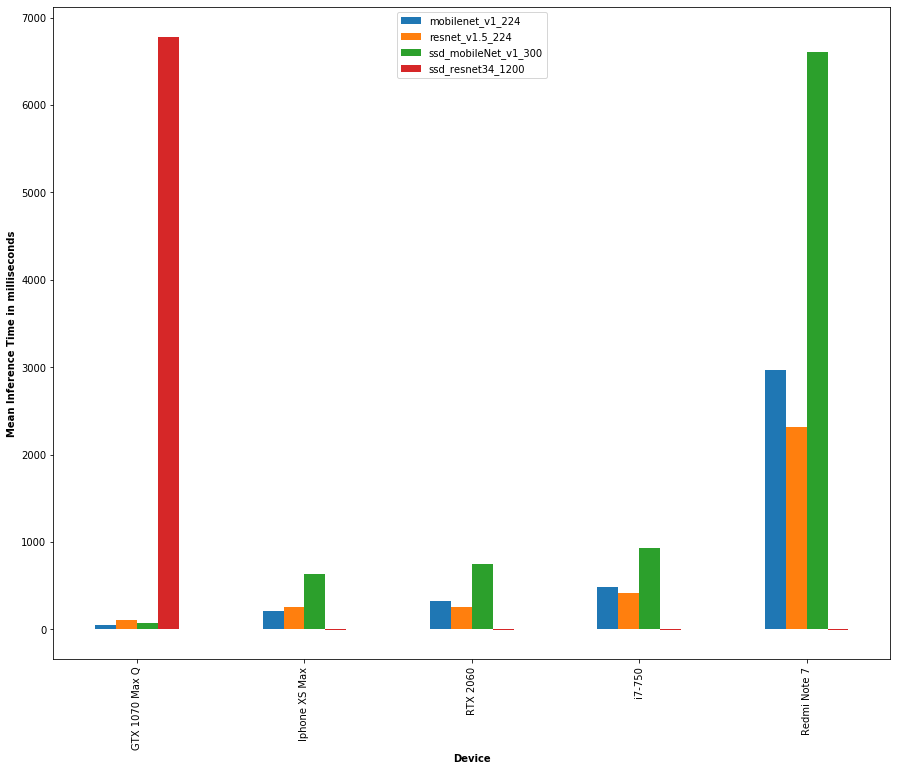

In [7]:
# plot grouped bar
dfs=[f"dev{x}.csv" for x in range(1,6)]
dfs = list(map(lambda x:( process_df(x)[['mean']],x.split('.')[0] ),dfs))

dfs=sorted(dfs,key=lambda x:x[0].loc['mobilenet_v1_224'][0])
dfs,devices= zip(*dfs)

per_device_means=list(map(lambda x:x[["mean"]].values.ravel().tolist(),dfs))
per_model_means = list(zip(*per_device_means))

means_df=pd.DataFrame(per_device_means,index=[device_names[x] for x in devices],columns=dfs[0].index.tolist())  
devices_df = means_df.transpose()
ax=means_df.plot(kind="bar",figsize=(15,12))
ax.set_xlabel('Device', fontweight='bold')
ax.set_ylabel('Mean Inference Time in milliseconds', fontweight='bold');
plt.savefig("model_grouped.png")

In [8]:
# Corr devices
cm = sns.light_palette("yellow", as_cmap=True)
corr = devices_df.corr()
corr.style.background_gradient(cmap=cm)

,GTX 1070 Max Q,Iphone XS Max,RTX 2060,i7-750,Redmi Note 7
GTX 1070 Max Q,1,-0.692056,-0.713916,-0.801255,-0.7254
Iphone XS Max,-0.692056,1,0.986368,0.974104,0.98417
RTX 2060,-0.713916,0.986368,1,0.99097,0.999807
i7-750,-0.801255,0.974104,0.99097,1,0.993068
Redmi Note 7,-0.7254,0.98417,0.999807,0.993068,1


In [9]:
corr_matrix = devices_df.corr().abs()
corr_pairs = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
print(corr_pairs)

RTX 2060        Redmi Note 7     0.999807
i7-750          Redmi Note 7     0.993068
RTX 2060        i7-750           0.990970
Iphone XS Max   RTX 2060         0.986368
                Redmi Note 7     0.984170
                i7-750           0.974104
GTX 1070 Max Q  i7-750           0.801255
                Redmi Note 7     0.725400
                RTX 2060         0.713916
                Iphone XS Max    0.692056
dtype: float64


In [10]:
# Corr models
cm = sns.light_palette("orange", as_cmap=True)
corr = means_df.corr()
corr.style.background_gradient(cmap=cm)

,mobilenet_v1_224,resnet_v1.5_224,ssd_mobileNet_v1_300,ssd_resnet34_1200
mobilenet_v1_224,1,0.999344,0.999049,-0.348606
resnet_v1.5_224,0.999344,1,0.999155,-0.336652
ssd_mobileNet_v1_300,0.999049,0.999155,1,-0.35617
ssd_resnet34_1200,-0.348606,-0.336652,-0.35617,1


In [11]:
corr_matrix = means_df.corr().abs()
corr_pairs = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
print(corr_pairs)

mobilenet_v1_224      resnet_v1.5_224         0.999344
resnet_v1.5_224       ssd_mobileNet_v1_300    0.999155
mobilenet_v1_224      ssd_mobileNet_v1_300    0.999049
ssd_mobileNet_v1_300  ssd_resnet34_1200       0.356170
mobilenet_v1_224      ssd_resnet34_1200       0.348606
resnet_v1.5_224       ssd_resnet34_1200       0.336652
dtype: float64
